In [1]:
import pandas as pd 
import torch
import torch.nn as nn
import numpy as np
# from AutoODE import LWR_batch_version 
import sys 
sys.path.append("..")
from DNN import LWRDataset, train_LWR, eval_LWR, test_LWR

In [2]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils import data
#device = "cuda" 
device = "cpu" 

class LWR_batch_version(nn.Module):
    def __init__(self, nx, dx, dt, kj, vf, tskip, plm = True, plm_vf = True, initial='random', boundary='zeros',
                fix_vf=False, parstep=1): 
        super(LWR_batch_version, self).__init__()
        self.nx = nx
        #xi are the locations along distance where data is available
        self.xi = [] 
        self.tskip = tskip 
#         self.y_max = y_max 
#         self.y_min = y_min 
        self.cmps=["k","q","u"]  #density, flow, velocity
#         self.initial={}
#         self.boundary={}
        
        self.initial = {} # shape: [batch, 3, # sensors]
        self.boundary = {} # shape: [batch, seq_len, 3]
            
        #factor by which parameter resolution is reduced with respect to nx
        self.parstep=parstep
        self.flag = plm 
        
        # use piecewise linear function for kj
        if plm == False: 
            self.kappa = torch.nn.Parameter(torch.tensor(kj[::self.parstep]), requires_grad=True)
#             print(self.kappa, self.kappa.shape)
        else: 
            self.plm = PiecewiseLinearModel(n_breaks = 2, num_regions = self.nx).to(device)
        
        #characteristic velocity vf
        if not fix_vf:
            self.vf=torch.nn.Parameter(torch.tensor(vf[::self.parstep]), requires_grad=True)
#             self.plm = PiecewiseLinearModel(n_breaks = 2, num_regions = self.nx, x = vf)
        else:
            self.vf=torch.tensor(vf[::self.parstep])
        
        self.dx = torch.tensor(dx)
        self.dt = torch.tensor(dt)
        
    def forward(self, xi, initial, boundary, tsteps): 
        self.xi = xi 
        nt=tsteps 
        self.initial = torch.nn.Parameter(initial).to(device)
        self.boundary = torch.nn.Parameter(boundary).to(device)

        batch_size = self.initial.shape[0]
       
        self.k = [self.initial[:, 0]]
        self.q = [self.initial[:, 1]]
        self.u = [self.initial[:, 2]]
        
        #initial values at output points
        self.ki=[self.initial[:, 0][:, self.xi[0]]]
        self.ui=[self.initial[:, 1][:, self.xi[0]]]
        self.qi=[self.initial[:, 2][:, self.xi[0]]]
#         print("k", self.k[0].shape)
        for n in range(1, nt):
            #This corresponds to the upwind scheme according to Gaddam et al. (2015).
            nk=torch.zeros((batch_size, nx), requires_grad=True).double().to(device)
            nu=torch.zeros((batch_size, nx), requires_grad=True).double().to(device)
            nq=torch.zeros((batch_size, nx), requires_grad=True).double().to(device)
            
            #new values for 3 variables stored in one tensor per time step
            nk[:, 0] = self.boundary[:, 0, n]
            nq[:, 0] = self.boundary[:, 1, n]
            nu[:, 0] = self.boundary[:, 2, n] 
            
            #full-resolution tensor hkappa and hv1, from down-sampled versions
            idx=torch.arange(self.nx) / self.parstep
            if self.flag: 
                hkappa = kappa[:, n - 1]
            else: 
                hkappa=self.kappa[idx.long()]
            hvf=self.vf[idx.long()] #.repeat(batch_size, 1)

            nk[:, 1:] = self.k[n-1][:, 1:] - 0.0016 * self.dt / self.dx * (self.q[n-1][:, 1:]-self.q[n-1][:, :-1]) 
#             idx = nk < 0. 
#             nk[idx] = 0.01 
            nu[:, 1:] = hvf[1:] * (1 - nk[:, 1:] / hkappa[1:])
#             idx = nu < 0.
#             nu[idx] = 2  
            nq[:, 1:] = nk[:, 1:] * nu[:, 1:] 
#             idx = nq < 0.
#             nq[idx] = 0.2  
            


            self.k.append(nk)
            self.u.append(nu)
            self.q.append(nq) 
            
            #only output every tskip timesteps
            if (n % self.tskip) == 0: 
                self.ki.append(nk[:, self.xi[0]])
                self.ui.append(nu[:, self.xi[0]])
                self.qi.append(nq[:, self.xi[0]])

        pred = torch.stack([torch.stack(self.ki, dim = 1),torch.stack(self.qi, dim = 1),torch.stack(self.ui, dim = 1)], dim = 1) 
        
        return pred[:, :, 1:, 1:] 

In [3]:
class LWR_Residual(nn.Module): 
    def __init__(self, input_dim, hidden_dim, output_dim): 
        super(LWR_Residual, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, output_dim) 
        )
    
    def forward(self, batch_size, x, t): 
#         x = x.permute(0, 2, 1).float().to(device)
#         x = x.reshape(x.shape[0], -1) 
        x_len = x.shape[0]
        t_len = t.shape[0]
        xx, tt = np.meshgrid(x.cpu().data.numpy(), t.cpu().data.numpy())
        X = torch.tensor(np.vstack((np.ravel(xx), np.ravel(tt))).T).repeat(batch_size, 1, 1).float().to(device)
#         print(X.shape)
        outputs = []

        for i in range(t.shape[0]): 
            out = self.fc(X[:, i * x_len : i * x_len + x_len, :].reshape(batch_size, -1).float())
            outputs.append(out)
        outputs = torch.stack(outputs)
#         print(outputs.shape)
        outputs = outputs.permute(1, 0, 2)
        outputs = outputs.reshape((batch_size, t_len, 3, x_len))
        outputs = outputs.permute(0, 2, 1, 3)
#         print(outputs.shape) 
        return outputs

class LWR_residual(nn.Module): 
    def __init__(self, LWR, x_size): 
        super(LWR_residual, self).__init__()
        self.LWR_model = LWR.to(device)
#         LWR_w(nx, dx, dt, kj, vf, tskip, plm = True, plm_vf = False, 
#                           initial={}, boundary={}, fix_vf=False, parstep=10).to(device)
        self.residual_model = LWR_Residual(x_size * 2, 512, x_size * 3)
    
    def forward(self, xi, initial, boundary, tsteps): 
#         print(xi.shape)
        x = torch.linspace(0, 1, xi.shape[1]).to(device)
        tt = torch.linspace(0, 1, 12).to(device) 
#         print(x.shape, tt.shape)
        pred = self.LWR_model(xi, initial, boundary, tsteps) 
        residual = self.residual_model(xi.shape[0], x, tt) 
#         print(pred.shape, residual.shape) 
        pred += residual[:, :, 1:, 1:] 
        
        return pred 

class LWR_seq2seq(nn.Module): 
    def __init__(self, LWR): 
        super(LWR_seq2seq, self).__init__()
        self.LWR_model = LWR.to(device) 
        for p in self.LWR_model.parameters(): 
            p.requires_grad = False 
#         LWR_w(nx, dx, dt, kj, vf, tskip, plm = True, plm_vf = False, 
#                           initial={}, boundary={}, fix_vf=False, parstep=10).to(device)
        self.residual_model = Seq2Seq(input_dim = 231, hidden_dim = 512, output_dim = 231, num_layers = 1).to(device)
    
    def forward(self, xi, x, initial, boundary, tsteps): 
        with torch.no_grad():
            pred1 = self.LWR_model(xi, initial[:, 0], boundary[:, 0], tsteps) # first 12
            pred2 = self.LWR_model(xi, initial[:, 1], boundary[:, 1], tsteps) # last 12
        res = x[:, :, 1:13, 1:] - pred1.detach().clone() 

        residual = self.residual_model(res.float(), 12) # last 12

        pred = pred2.detach().clone()
        pred += residual # residual[:, :, 1:] 
        
        return pred.double() 

# class LWR_seq2seq(nn.Module): 
#     def __init__(self, LWR): 
#         super(LWR_seq2seq, self).__init__()
#         self.LWR_model = LWR.to(device) 
#         for p in self.LWR_model.parameters(): 
#             p.requires_grad = False 
# #         LWR_w(nx, dx, dt, kj, vf, tskip, plm = True, plm_vf = False, 
# #                           initial={}, boundary={}, fix_vf=False, parstep=10).to(device)
#         self.residual_model = Seq2Seq(input_dim = 231, hidden_dim = 512, output_dim = 231, num_layers = 1).to(device)
    
#     def forward(self, xi, x, initial, boundary, tsteps): 
#         with torch.no_grad():
#             pred1 = self.LWR_model(xi, initial[:, 0], boundary[:, 0], tsteps) # first 12
#             pred2 = self.LWR_model(xi, initial[:, 1], boundary[:, 1], tsteps) # last 12
#         res = x[:, :, 1:12, 1:] - pred1.detach().clone() 

#         residual = self.residual_model(res.float(), 12) # last 12

#         pred = pred2.detach().clone()
#         pred += residual[:, :, 1:] 
        
#         return pred.double() 

In [4]:
import torch 

In [5]:
import os 

os.getcwd() 

'C:\\Users\\Stephen Ma\\Desktop\\AutoODE_PEMS_traffic\\nn\\visualization'

In [6]:
# LWR=torch.load("time_AutoODE1.pt", map_location=torch.device('cpu'))
# seq2seq = torch.load("../result/Seq2Seq/time/best_time_Seq2Seq1.pt", map_location=torch.device('cpu')) 
LWR=torch.load("../AutoODE_result/space/best_space_AutoODE3.pt", map_location=torch.device('cpu'))
seq2seq = torch.load("../result/Seq2Seq/space/best_space_Seq2Seq1.pt", map_location=torch.device('cpu')) 


In [19]:
# hybridLWR = torch.load("../AutoODE_result/time/time_hybridAutoODE2.pt", map_location=torch.device('cpu'))
hybridLWR = torch.load("../AutoODE_result/space/new_space_hybridAutoODE1.pt", map_location=torch.device('cpu')) 

In [20]:
hybridLWR["preds"].shape 

(53255, 3, 12, 77)

In [28]:
test_sensors = torch.tensor([3, 11, 13, 14, 15, 16, 19, 24, 27, 29, 31, 36, 38, 41, 50, 62,
       73, 75, 76]) - 1  
test_sensors 

tensor([ 2, 10, 12, 13, 14, 15, 18, 23, 26, 28, 30, 35, 37, 40, 49, 61, 72, 74,
        75])

In [7]:
LWR["trues"].shape, seq2seq["trues"].shape 

((53267, 3, 12, 19), (53256, 3, 12, 20))

In [30]:
LWR["trues"][111, 0, 0, :3], seq2seq["trues"][100, 0, 0, 1:4], hybridLWR["trues"][99, 0, 0, test_sensors][:3]

(array([0.02905112, 0.04562397, 0.05339333]),
 array([0.02905112, 0.04562397, 0.05339333], dtype=float32),
 array([0.02905112, 0.04562397, 0.05339333]))

In [40]:
full = np.concatenate((np.expand_dims(seq2seq["trues"][100, :, :, 0], axis=-1), LWR["trues"][111, :, :, ::]), axis = 2) 

In [36]:
np.expand_dims(seq2seq["trues"][100, :, :, 0], axis=-1).shape

(3, 12, 1)

In [42]:
LWR["trues"][3, 0, 0, :3], seq2seq["trues"][100, 0, 0, :3], full[0, 0, :3]

(array([0.02229968, 0.01375568, 0.01384004]),
 array([0.02779224, 0.02588739, 0.02377252], dtype=float32),
 array([0.02779224, 0.02588739, 0.02377252]))

In [11]:
out["model"].k[0].shape

torch.Size([414, 380])

In [12]:
out["model"].ki[-1].shape

torch.Size([414, 78])

In [14]:
import matplotlib.pyplot as plt

In [14]:
out["model"].xi.shape

torch.Size([414, 78])

In [10]:
dx=LWR["model"].dx.cpu().detach().numpy()
nx=LWR["model"].nx
xpos=np.linspace(0, (nx-1)*dx, nx)

In [11]:
xi=LWR["model"].xi.cpu().numpy()
xi.shape

(19, 20)

In [15]:
LWR["model"].ki[-1].shape 

torch.Size([19, 20])

In [20]:
xpos[xi[bi,:]].shape, seq2seq["trues"][1, 0, -1, :].shape 

((78,), (78,))

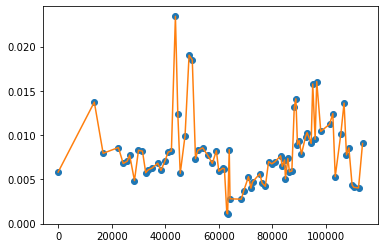

In [25]:
#batch id
bi=10 
plt.plot(xpos[xi[0, :]], seq2seq["trues"][1, 0, -1, :], linewidth=0,
        marker="o") 
plt.plot(xpos[xi[0, :]], seq2seq["trues"][1, 0, -1, :]) 

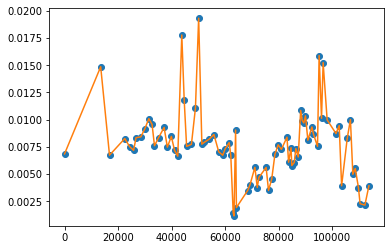

In [24]:
#batch id
bi=10 
plt.plot(xpos[xi[0, :]], seq2seq["preds"][1, 0, -1, :], linewidth=0,
        marker="o");
plt.plot(xpos[xi[0, :]], seq2seq["preds"][1, 0, -1, :]);

In [16]:
LWR["model"].k[-1][0,:].max()

tensor(0.0445, dtype=torch.float64)

In [17]:
ksnap=LWR["model"].k[-1][0,:].cpu().detach().numpy()
usnap=LWR["model"].u[-1][0,:].cpu().detach().numpy()

In [12]:
ksnap=seq2seq["trues"][100, 0, -1, :].numpy()
usnap=seq2seq["trues"][100, 0, -1, :].numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [18]:
np.save("k_snapshot_LWR.npy", ksnap)
np.save("u_snapshot_LWR.npy", usnap)
np.save("xpos_snapshot_LWR.npy", xpos)

In [14]:
kisnap=seq2seq["trues"][100, 0, -1, :]
uisnap=seq2seq["trues"][100, 2, -1, :]
np.save("ki_snapshot_LWR.npy", kisnap)
np.save("ui_snapshot_LWR.npy", uisnap)
np.save("xi_snapshot_LWR.npy", xi[0,:])